In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR

import torch

from captum.concept import TCAV, Concept
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

from eegatscale.transforms import Standardize
from concept_classifier import TCAVClassifier

In [214]:
transform = Standardize()

In [215]:
# load pickle file
# file_path = 'sanity_check_concepts_MMIDB/Beta_Auditory Association Cortex-lh/S006R04_7_Beta_Auditory Association Cortex-lh.pkl'
file_path = "/scratch/s194101/concepts/TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Early Visual Cortex-lh/aaaaaaem_s008_t001_25_Alpha_Early Visual Cortex-lh.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

In [216]:
data.shape
# data[0][-1]
# last channel is just -1's

torch.Size([19, 1024])

In [217]:
name = "Beta_Auditory Association Cortex-lh"
concepts_dir = 'sanity_check_concepts_MMIDB'

In [218]:
def get_tensor_from_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    # turn to float32
    data = torch.tensor(data, dtype=torch.float32)
    data = transform(data)

    return torch.tensor(data).squeeze(0)

In [219]:
data = get_tensor_from_pickle_file(file_path)
data.shape

/tmp/ipykernel_3532436/3864923467.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3532436/3864923467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data).squeeze(0)


torch.Size([19, 1024])

In [220]:
# make the folder a concept

def assemble_concept(name, id, concepts_path):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_pickle_file, concept_path)
    concept_iter = dataset_to_dataloader(dataset)


    return Concept(name=name, id=id, data_iter=concept_iter)

In [221]:
# concept_1 = assemble_concept("Beta_Auditory Association Cortex-lh", 0, concepts_dir)
# concept_2 = assemble_concept("Beta_Auditory Association Cortex-rh", 1, concepts_dir)
# concept_3 = assemble_concept("Delta_Posterior Opercular Cortex-rh", 2, concepts_dir)

concept_1 = assemble_concept("random_left_concept_MMIDB_Alpha_sanity_check", 0, "/scratch/s194101/concepts")
concept_2 = assemble_concept("random_right_concept_MMIDB_Alpha_sanity_check", 1, "/scratch/s194101/concepts")

In [222]:
concept_1

Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check')

In [223]:
random_1 = assemble_concept("random_tuh_alpha", 2, "/scratch/s194101/concepts")

In [224]:
random_1

Concept(2, 'random_tuh_alpha')

In [225]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

/home/s194101/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/s194101/Bachelors-explainability/eegatscale/models/linearheadbendr.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt
model loaded


/tmp/ipykernel_3532436/4230208419.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]


# See if the model can handle both inputs:

In [226]:
x = next(iter(concept_1.data_iter))
x.shape

/tmp/ipykernel_3532436/3864923467.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3532436/3864923467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data).squeeze(0)


torch.Size([64, 19, 1024])

In [227]:
model(x)

# test model
model(x).argmax(dim=1)

/home/s194101/.conda/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [228]:
# print(model)
# layers = ["enc_augment", "summarizer"]
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]
experimental_sets = [[concept_1, random_1], [concept_2, random_1]]
tcav = TCAV(model, layers, classifier=TCAVClassifier())

In [229]:
experimental_sets

[[Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check'),
  Concept(2, 'random_tuh_alpha')],
 [Concept(1, 'random_right_concept_MMIDB_Alpha_sanity_check'),
  Concept(2, 'random_tuh_alpha')]]

In [230]:
tcav_scores = tcav.interpret(inputs=x, experimental_sets=experimental_sets, target=0)

/tmp/ipykernel_3532436/3864923467.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3532436/3864923467.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data).squeeze(0)


/home/s194101/.conda/envs/myenv/lib/python3.11/site-packages/captum/_utils/av.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  av = torch.load(fl)
/home/s194101/.conda/e

In [231]:
tcav_scores

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-2': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0.8281, 0.1719]),
                           'magnitude': tensor([ 0.0260, -0.0260])},
                          'enc_augment': {'sign_count': tensor([0.5469, 0.4531]),
                           'magnitude': tensor([ 0.0088, -0.0088])},
                          'summarizer': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 1.4801, -1.4801])},
                          'extended_classifier': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.1483, -0.1483])},
                          'clf': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.2503, -0.2503])}}),
             '1-2': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0., 1.]),
                           'magnitude': t

In [232]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

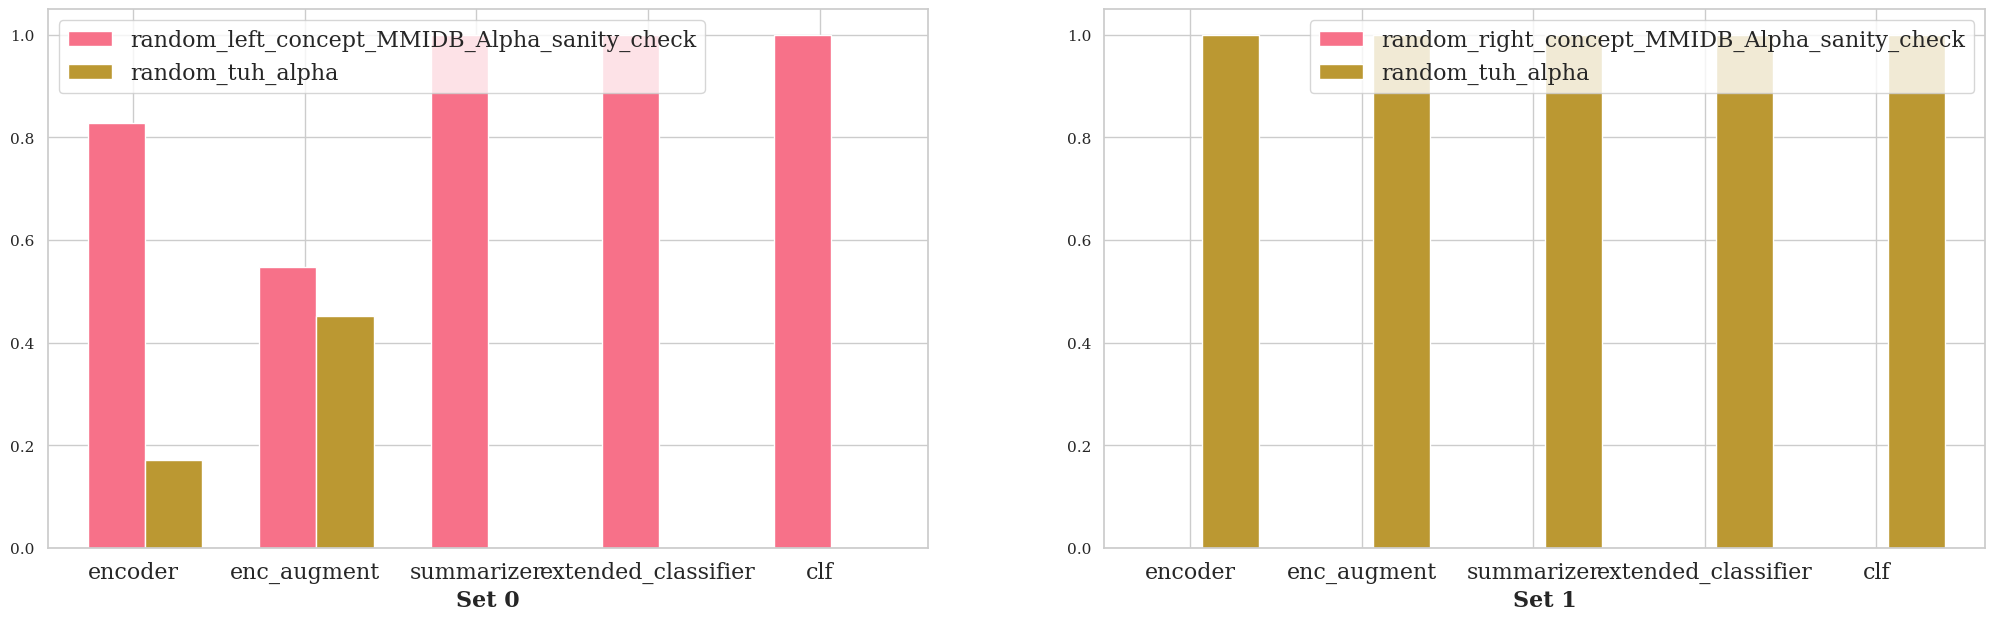

In [233]:
plot_tcav_scores(experimental_sets, tcav_scores)

In [234]:
tcav_scores

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-2': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0.8281, 0.1719]),
                           'magnitude': tensor([ 0.0260, -0.0260])},
                          'enc_augment': {'sign_count': tensor([0.5469, 0.4531]),
                           'magnitude': tensor([ 0.0088, -0.0088])},
                          'summarizer': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 1.4801, -1.4801])},
                          'extended_classifier': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.1483, -0.1483])},
                          'clf': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 0.2503, -0.2503])}}),
             '1-2': defaultdict(None,
                         {'encoder': {'sign_count': tensor([0., 1.]),
                           'magnitude': t